# Deep Learning: RNN: Disaster Tweets
**Thomas Bohn**   --   **2025-09-20**

--  [Main Report](https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets/blob/main/deep-learing-rnn-disaster-tweets.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets)  --

# 1.&nbsp;Introduction

**Problem Statement**

Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

A prediction should be made whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**Why is it Important?**

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

**Related Kaggle Competion**

[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview)

**DataSet Description**

Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

**Files Include**
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

**Columns Definitions**
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

**Data Facts**
- **Data Size**: 1.43 MB
- **Training Data Records**: 7,613
- **Training Data Records**: 3,263
- **Classes**: 2 (Binary)

## Python Libraries

The following python libraries are used in this notebook.

In [50]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

###################################

# NLP
import string, re, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

###################################

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

#################################

# Import Tensor Flow and Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    BatchNormalization,
    Dense,
    TimeDistributed,
    Dropout,
    Bidirectional,
    Flatten,
    GlobalMaxPool1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    History,
    ModelCheckpoint
)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2


#################################

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

print('#### ALL DONE! ####')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
#### ALL DONE! ####


## Import Git Repo

In [2]:
# Remove existing directory if it exists
repo_dir = '/content/MsDS-deep-learing-rnn-disaster-tweets'
if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)
    print(f"Removed existing directory: {repo_dir}")

# Clone your repository
!git clone https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets.git

# Add to Python path
import sys
sys.path.append(repo_dir)

Removed existing directory: /content/MsDS-deep-learing-rnn-disaster-tweets
Cloning into 'MsDS-deep-learing-rnn-disaster-tweets'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 42), reused 42 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 312.86 KiB | 1.63 MiB/s, done.
Resolving deltas: 100% (42/42), done.


## Global Variables

The following are global variables referenced in this notebook.

In [3]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [4]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive. A copy of the code from Kaggle was cached on google drive for development in a colab environment.

## Import GloVe

In [5]:
# Define the source of the zipped data files
target_file = 'glove.6B.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'glove.6B.50d.txt', 'submission_rnn_best_model_final.csv', 'MsDS-deep-learing-rnn-disaster-tweets', 'glove.6B.300d.txt', 'glove.6B.200d.txt', 'glove.6B.zip', 'nlp-getting-started.zip', 'test.csv', 'glove.6B.100d.txt', 'sample_submission.csv', 'model.h5', 'drive', 'train.csv', 'sample_data']


In [6]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [7]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_glove   = file_path_root + '/glove.6B.100d.txt'

print("GloVe File Path:", file_path_glove)

GloVe File Path: /content/glove.6B.100d.txt


## Import the Data

In [8]:
# Define the source of the zipped data files
target_file = 'nlp-getting-started.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'glove.6B.50d.txt', 'submission_rnn_best_model_final.csv', 'MsDS-deep-learing-rnn-disaster-tweets', 'glove.6B.300d.txt', 'glove.6B.200d.txt', 'glove.6B.zip', 'nlp-getting-started.zip', 'test.csv', 'glove.6B.100d.txt', 'sample_submission.csv', 'model.h5', 'drive', 'train.csv', 'sample_data']


In [9]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [10]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_train   = file_path_root + '/train.csv'
file_path_test    = file_path_root + '/test.csv'
file_path_sample  = file_path_root + '/sample_submission.csv'

# Load train labels from CSV file
train_labels = pd.read_csv(file_path_train)

# Load test labels from CSV file
test_labels = pd.read_csv(file_path_test)

# Load test labels from CSV file
sample_output = pd.read_csv(file_path_sample)

## Create Label Mappings

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [11]:
 # Encoding of labels
label_dict = {'not': 0, 'disaster': 1}
# Create the inverse dictionary
inverted_label_dict = {0: 'not', 1: 'disaster'}
print('label_dict:', label_dict)
print('inverted_label_dict:', inverted_label_dict)

label_dict: {'not': 0, 'disaster': 1}
inverted_label_dict: {0: 'not', 1: 'disaster'}


## Add Basic Columns

In [12]:
# Add Additional Columns to training data
train_labels['label']=train_labels['target']
train_labels['length']=train_labels['text'].str.len()
train_labels['word_count']=train_labels['text'].str.split().str.len()

# Add Additional Columns to testing data
test_labels['length']=test_labels['text'].str.len()
test_labels['word_count']=test_labels['text'].str.split().str.len()

## Preview Data

In [13]:
if gDEBUG:
  # Preview the Data Sources
  print("Sample of Training Labels")
  display(train_labels.head(5))
  print()
  print("Sample of Testing Data")
  display(test_labels.head(5))
  print()
  print("Sample of Results Output:")
  display(sample_output.head(5))

Sample of Training Labels


,id,keyword,location,text,target,label,length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,88,16



Sample of Testing Data


,id,keyword,location,text,length,word_count
0,0,NaN,NaN,Just happened a terrible car crash,34,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45,8



Sample of Results Output:


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [14]:
# Display training labels info
print("Training Labels Info:")
print(train_labels.info())
print()
# Display testing labels info
print("Testing Data Info:")
print(test_labels.info())
print()

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   label       7613 non-null   int64 
 6   length      7613 non-null   int64 
 7   word_count  7613 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 475.9+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3263 non-null   int64 
 1   keyword     3237 non-null   object
 2   location    2158 non-null   object
 3   text        3263 non-null   object
 4   length      3263 non-null   int64 
 5   word

In [15]:
 # Preview the Training Label Assignments
print('Label Count of Training Labels')
display(train_labels['target'].value_counts())
print()
print('Imbalance of Labels:', round((train_labels['target'].value_counts()[1]
                                    - train_labels['target'].value_counts()[0]) / len(train_labels), 3))


Label Count of Training Labels


,count
target,
0,4342
1,3271



Imbalance of Labels: -0.141


In [16]:
# Example of the text from the article
example_text = train_labels['text'].iloc[100]
# Print to Screen
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Length of Text: 124 

.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion
https://t.co/gFJfgTodad


# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

Import EDA functions from the separate library file.

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [17]:
# Import EDA functions from the nlp_utils package
from nlp_utils import (
    replace_labels,
    create_data_by_label,
    quick_table_details,
    count_field,
    shape_df_for_stacked_barchart,
    create_single_stacked_bar,
    viz_class_frequency,
    viz_char_frequency,
    viz_word_frequency,
    viz_word_length_frequency
)

print("✅ EDA functions imported successfully from GitHub!")

✅ EDA functions imported successfully from GitHub!


## EDA Analysis: Overview

In [18]:
# Print summary details for the 3 tables in the datasource
quick_table_details (df_name="train_labels", df=train_labels, level_of_detail = 4)


#### train_labels ####
number of features (columns) = 8
number of observations (rows) = 7613
---------------------------- 

DataType Counts:
int64     5
object    3
Name: count, dtype: int64
---------------------------- 

Columns:
Index(['id', 'keyword', 'location', 'text', 'target', 'label', 'length',
       'word_count'],
      dtype='object')
---------------------------- 

Description:
                  id     keyword location  \
count    7613.000000        7552     5080   
unique           NaN         221     3341   
top              NaN  fatalities      USA   
freq             NaN          45      104   
mean     5441.934848         NaN      NaN   
std      3137.116090         NaN      NaN   
min         1.000000         NaN      NaN   
25%      2734.000000         NaN      NaN   
50%      5408.000000         NaN      NaN   
75%      8146.000000         NaN      NaN   
max     10873.000000         NaN      NaN   

                                                     text      tar

In [19]:
# show the content of one Article in the data source
print(textwrap.fill(train_labels['text'][55], width=100))

#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen
Front in #Diyala http://t.co/4IzFdYC3cg


In [20]:
#print column names for each table
print('columns in df_train:', train_labels.columns)
# calculate the count of records in each category
df_cat_count = count_field(df = train_labels, field = 'target')
display(df_cat_count)

columns in df_train: Index(['id', 'keyword', 'location', 'text', 'target', 'label', 'length',
       'word_count'],
      dtype='object')


,target,count,Pct of Total,Pct of Total Text
0,0,4342,0.57,56 %
1,1,3271,0.43,43 %


        count
target       
0        4342
1        3271 

[-] the catgory of 0 makes up 56 % of the data.
[-] the catgory of 1 makes up 43 % of the data.


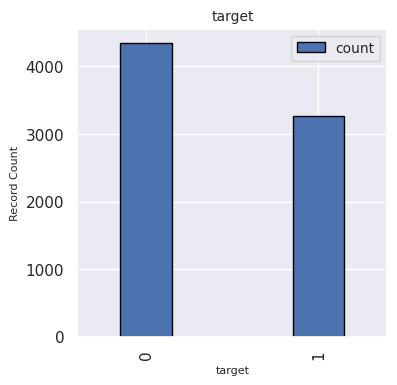

In [21]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = train_labels, group_by = 'target', stack_by = 'target', fig_size = (4,4), normalize = False, gDEBUG = gDEBUG)
table = shape_df_for_stacked_barchart(df = train_labels, group_by = 'target', stack_by = 'target', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count)):
    print('[-] the catgory of', df_cat_count['target'].iloc[i], 'makes up',
           df_cat_count['Pct of Total Text'].iloc[i], 'of the data.')

## EDA Analysis: Text Distribution

Size of the data by label dictionary: 2 

[4342, 3271]
['not', 'disaster']


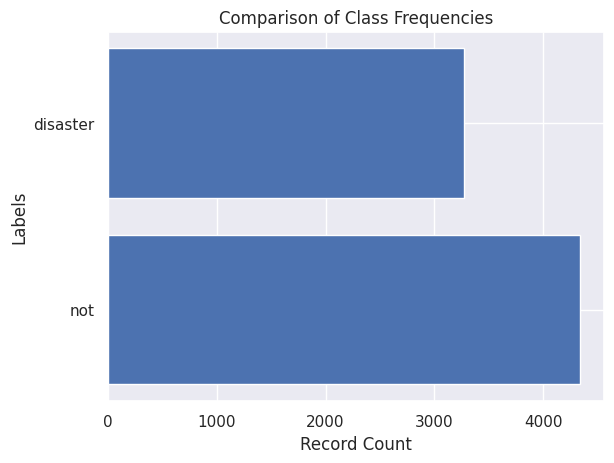

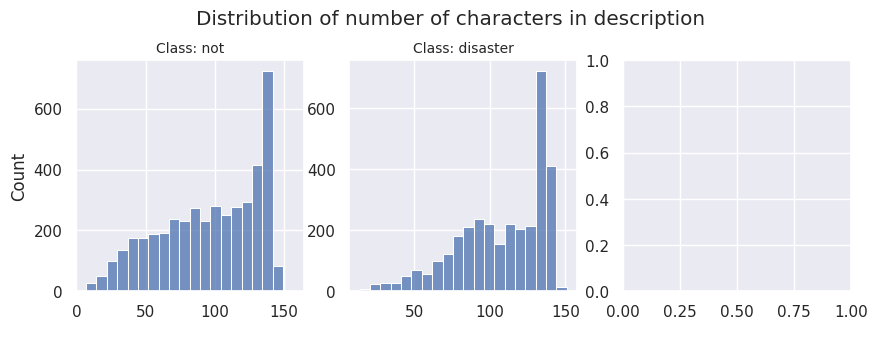

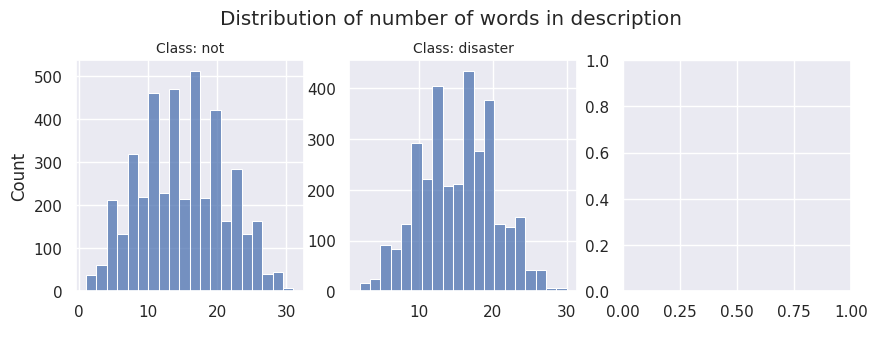

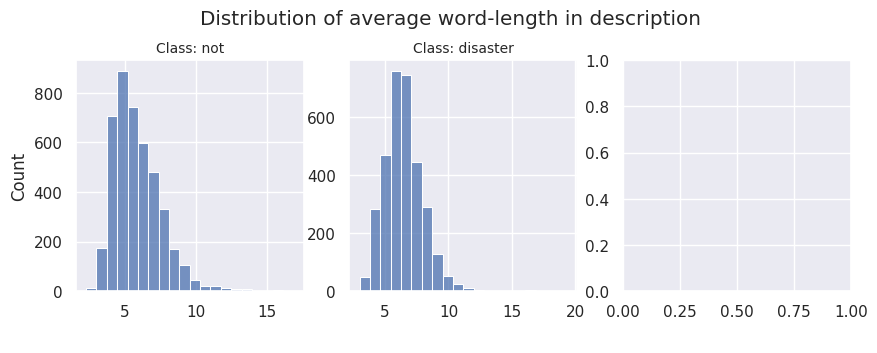

In [22]:
data_by_label = create_data_by_label(data=train_labels, label_col='label')
# Distribution of number of characters in description
viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of characters in description
viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

## EDA Results

ADD HERE

# 4.&nbsp;Data Cleansing & Text Normalization

Address missing values and duplicates, followed by a series of text preprocessing steps. Text pre-processing includes converting text to lowercase, removing punctuation, handling HTML tags, and applying stemming/lemmatization. These cleaning functions ensure the data is standardized and ready for further analysis.

## Core Normalization Functions

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.*italicized text*

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [23]:
# Import text processing functions from the nlp_utils package
from nlp_utils import (
    convert_to_lowercase,
    remove_whitespace,
    remove_punctuation,
    remove_html,
    remove_emoji,
    remove_http,
    convert_acronyms,
    convert_contractions,
    remove_stopwords,
    pyspellchecker,
    text_stemmer,
    text_lemmatizer,
    discard_non_alpha,
    keep_pos,
    remove_additional_stopwords,
    text_normalizer,
    apply_text_normalizer
)

print("Text processing functions imported successfully from nlp_utils package")


Text processing functions imported successfully from nlp_utils package


## Apply Text Normalization

In [24]:
%%time
# Apply text normalization
data_train_norm, data_test_norm, data_train, data_test  = apply_text_normalizer(train_labels, test_labels)

Size of the training set: 7613
Size of the test set: 3263

Labels in training set: 2
Labels in test set: No label column (added as null)

Sample of test set [normalized]:

Columns in test set [normalized]: Index(['normalized_text', 'label'], dtype='object') 

                                     normalized_text  label
0                          deed reason hashtag allah      1
1                             fire ronge sask canada      1
2  resident ask shelter place officer evacuation ...      1

Sample of test set [data]:

Columns in test set [data]: Index(['id', 'keyword', 'location', 'text', 'length', 'word_count',
       'normalized_text'],
      dtype='object') 

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  labe

In [25]:
if gDEBUG:
  # Preview the changes for the before and after text
  print(textwrap.fill(data_train['text'][0], width=100))
  print('\n## change to ##\n')
  print(textwrap.fill(data_train['normalized_text'][0], width=100))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

## change to ##

deed reason hashtag allah


# 5.&nbsp;Word Embeddings + Vectorization

XXXXX

## Word Embeddings from GloVe

In [26]:
train_texts = data_train_norm['normalized_text'].values
train_target = data_train_norm['label'].values.astype('int')
test_texts = data_test['normalized_text'].values
test_ids = data_test['id'].values

In [27]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

9343

In [28]:
# Pad_sequences
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(train_texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_texts),
    length_long_sentence,
    padding='post'
)

test_padded_sentences = pad_sequences(
    embed(test_texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[2679,  304,    1, ...,    0,    0,    0],
       [   5, 3979, 3980, ...,    0,    0,    0],
       [1499,  371, 1745, ...,    0,    0,    0],
       ...,
       [1154,  343,  963, ...,    0,    0,    0],
       [  31,  633,   89, ...,    0,    0,    0],
       [  28,  275,   40, ...,    0,    0,    0]], dtype=int32)

In [29]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open(file_path_glove) as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [30]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08529   , -0.0055903 , -0.1912    , ...,  0.13009   ,
        -0.21062   ,  0.69775999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.31197   , -0.25681001,  1.07260001, ...,  0.28439   ,
         0.060037  , -0.068896  ],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

# 6.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Test Data Split Execution

In [31]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded_sentences,
    train_target,
    test_size=0.2,
    stratify=train_target,
    random_state=27
)

In [32]:
# Preview Output
if gDEBUG:
  print(X_train[:2])
  print(y_train[:4])
  print(X_val[:2])
  print(y_val[:4])

[[ 144  345   21  419  420    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 309  191 5635   11  353 1053  841  209  413  656    0    0    0    0
     0    0    0    0    0    0    0]]
[1 0 1 0]
[[ 85   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 54   4 373 395   6  49 243   1   1   0   0   0   0   0   0   0   0   0
    0   0   0]]
[0 1 0 0]


# 7.&nbsp; Baseline Models: LSTM (RNN)

## Model Functions

In [33]:
# Display a learning curve and a loss curve
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

In [34]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [35]:
# Define a time element to add to history of model training
class EpochTimeHistory(Callback):
    """A custom Keras callback to record the duration of each epoch."""
    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time at the beginning of each epoch
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the epoch's duration
        epoch_duration = time.time() - self.epoch_start_time

        # Add the duration to the logs dictionary.
        # Keras will automatically include this in the final history object.
        if logs is not None:
            logs['epoch_duration'] = epoch_duration

In [36]:
#ensure the output directory for saved models exists
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
os.makedirs(save_dir, exist_ok=True) # This creates the folder if it doesn't exist

## Build the Model Architecture

In [37]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

def glove_lstm():
    # Build the model
    model = Sequential()
    # Cofigure the architecture
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix]
    ))
    # Cofigure the architecture
    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))
    # Cofigure the architecture
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    # Compile the model
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [38]:
# Create an instance of the model
model_0 = glove_lstm()
# Manually build the model
model_0.build(input_shape=(None, length_long_sentence))
# Display the model summary
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 21, 100)        │       934,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 21, 42)         │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 42)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │           462 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 956,351 (3.65 MB)

 Trainable params: 956,267 (3.65 MB)

 Non-trainable params: 84 (336.00 B)

## Train/Fit the Model

In [39]:
# Callbacks for early stopping and reducing learning rate
time_history_callback_0 = EpochTimeHistory()
early_stopping_0 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_0 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

In [40]:
history_0 = model_0.fit(
    X_train,
    y_train,
    epochs = 30,
    batch_size = 64,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [early_stopping_0, reduce_lr_0, time_history_callback_0]
)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.4976 - loss: 1.0323 - val_accuracy: 0.5831 - val_loss: 0.6758 - learning_rate: 0.0010 - epoch_duration: 22.5950
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5862 - loss: 0.7272 - val_accuracy: 0.6691 - val_loss: 0.6504 - learning_rate: 0.0010 - epoch_duration: 4.5028
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6773 - loss: 0.6192 - val_accuracy: 0.7354 - val_loss: 0.5841 - learning_rate: 0.0010 - epoch_duration: 7.5663
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.7064 - loss: 0.5859 - val_accuracy: 0.7781 - val_loss: 0.5221 - learning_rate: 0.0010 - epoch_duration: 7.7027
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7381 - loss: 0.5446 - val_accuracy: 0.7741 - val_loss: 0.4881 - learning_rate: 0.0010 - epoch_duration: 4.9778
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7708 - loss: 0.5236 - val_accuracy: 0.7774 - val_loss

In [41]:
# Save the model and the history
model_0_path = os.path.join(save_dir, 'rnn_model_0.keras')
history_0_path = os.path.join(save_dir, 'rnn_history_0.pkl')
model_0.save(model_0_path)
with open(history_0_path, 'wb') as f:
    pickle.dump(history_0.history, f)

print(f"History saved to {save_dir}")

History saved to /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models


## Evaluate the Model

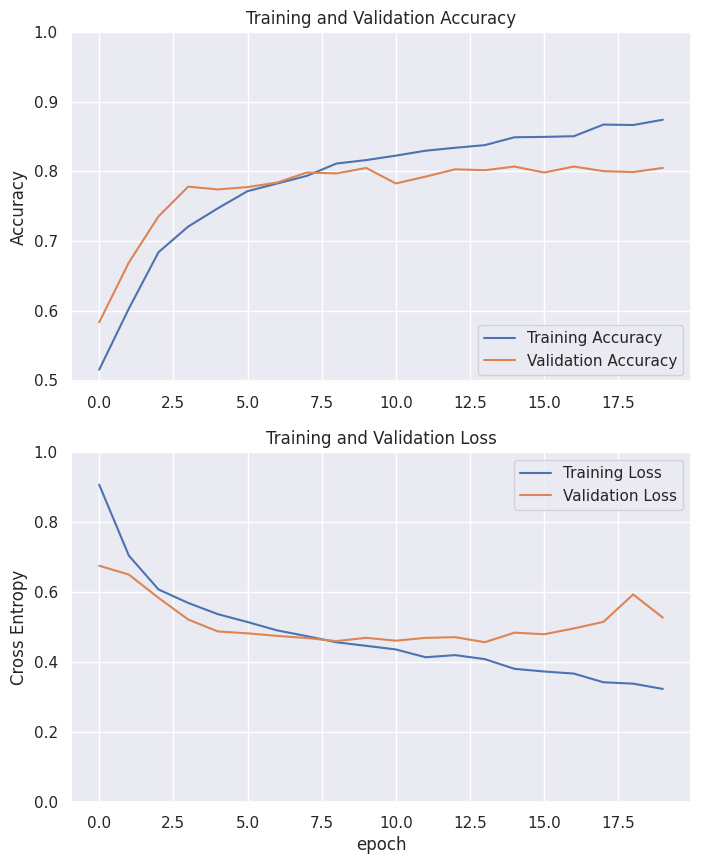

In [42]:
# Display the learning curve and loss curve
learning_curve(history_0)

In [43]:
loss, accuracy = model_0.evaluate(X_val, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7958 - loss: 0.4723
Loss: 0.45730307698249817
Accuracy: 0.8017071485519409


In [44]:
pred_val = model_0.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
F1-score:  0.7396551724137931
Precision:  0.6559633027522935
Recall:  0.8478260869565217
Acuracy:  0.8017071569271176
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1017
           1       0.66      0.85      0.74       506

    accuracy                           0.80      1523
   macro avg       0.78      0.81      0.79      1523
weighted avg       0.83      0.80      0.81      1523



# 8.&nbsp; Architecture Tuning

## Improved Architecture

In [59]:
def glove_lstm_v2():
    # Build the model
    model = Sequential()
    # Cofigure the architecture
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        trainable = False
    ))
    # Cofigure the architecture - Layer 1
    model.add(
        Bidirectional(LSTM(
            128,
            return_sequences = True,
            dropout=0.3,
            recurrent_dropout=0.2
        ))
    )
    model.add(BatchNormalization())

    # Cofigure the architecture - Layer 2
    model.add(
        Bidirectional(LSTM(
            64,
            return_sequences = True,
            dropout=0.3,
            recurrent_dropout=0.2
        ))
    )
    model.add(BatchNormalization())

    model.add(GlobalMaxPool1D())

    # Cofigure the architecture
    model.add(Dense(
        128,
        activation = "relu",
        kernel_regularizer=l1_l2(l1=0.01, l2=0.01)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(
        64,
        activation = "relu"
    ))
    model.add(Dropout(0.3))
    model.add(Dense(
        1,
        activation = 'sigmoid'
    ))
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

In [60]:
# Create an instance of the model
model_1 = glove_lstm_v2()
# Manually build the model
model_1.build(input_shape=(None, length_long_sentence))
# Display the model summary
model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 21, 100)        │       934,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 21, 256)        │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 21, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,517 (5.19 MB)

 Trainable params: 424,449 (1.62 MB)

 Non-trainable params: 935,068 (3.57 MB)

## Train/Fit the Model

In [ ]:
# Callbacks for early stopping and reducing learning rate
time_history_callback_1 = EpochTimeHistory()
early_stopping_1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)


history_1 = model_1.fit(
    X_train,
    y_train,
    epochs = 30,
    batch_size = 64,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [early_stopping_1, reduce_lr_1, time_history_callback_1]
)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.6338 - loss: 11.4661 - precision: 0.5852 - recall: 0.5550 - val_accuracy: 0.7643 - val_loss: 4.1086 - val_precision: 0.7886 - val_recall: 0.6162 - learning_rate: 0.0010 - epoch_duration: 45.0116
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.7543 - loss: 2.7747 - precision: 0.7428 - recall: 0.6563 - val_accuracy: 0.7748 - val_loss: 0.8070 - val_precision: 0.7403 - val_recall: 0.7324 - learning_rate: 0.0010 - epoch_duration: 42.3896
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.7754 - loss: 0.6836 - precision: 0.7658 - recall: 0.6757 - val_accuracy: 0.7741 - val_loss: 0.6265 - val_precision: 0.7468 - val_recall: 0.7171 - learning_rate: 0.0010 - epoch_duration: 40.4433
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 290ms/step - accuracy: 0.7661 - loss: 0.6292 - precision: 0.7656 - recall: 0.6663 - val_accuracy: 0.7833 - val_loss: 0.6000 - val_precision: 0.8227 - val_recall: 0.6315 - lea

In [ ]:
# Save the model and the history
model_1_path = os.path.join(save_dir, 'rnn_model_1.keras')
history_1_path = os.path.join(save_dir, 'rnn_history_1.pkl')
model_1.save(model_1_path)
with open(history_1_path, 'wb') as f:
    pickle.dump(history_1.history, f)

print(f"History saved to {save_dir}")

## Evaluate the Model

In [ ]:
# Display the learning curve and loss curve
learning_curve(history_1)

loss, accuracy = model_1.evaluate(X_val, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

pred_val = model_1.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

# 9.&nbsp;Final Prediction and Evaluation

## Import the Best and Final Model

In [ ]:
# Load the best model from the saved models
save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
model_best_path = os.path.join(save_dir, 'rnn_model_0.keras')
history_best_path = os.path.join(save_dir, 'rnn_history_0.pkl')

loaded_model_best = models.load_model(model_best_path)

with open(history_best_path, 'rb') as f:
    loaded_history_dict_best = pickle.load(f)

loaded_history_best = History()
loaded_history_best.history = loaded_history_dict_best
loaded_history_best.epoch = list(range(len(loaded_history_dict_best['loss'])))

## Review and Evaluate the Model

In [ ]:
# Review Model Architecture
loaded_model_best.summary()

In [ ]:
# Review the Accuracy and Validation Loss Charts
learning_curve(loaded_history_best)

In [ ]:
# Review the epoch results
loaded_history_best
history_best_df = pd.DataFrame(loaded_history_best.history)
history_best_df.index += 1
print("\n--- Full Training History with Epoch Times ---")
print(history_best_df)

In [ ]:
pred_val = loaded_model_best.predict(X_val)
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
show_metrics(label_pred_val, y_val)

# 10.&nbsp; Conclusions

{{xxxxx}}

## Results Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Prepare Submission


In [ ]:
best_model = model_0
pred_val = model_0.predict(test_padded_sentences)
print("number of predictions:", len(pred_val))
# Shape the data for submission
label_pred_val = (pred_val > 0.5).astype(int).reshape(-1)
ids = test_ids
submission_df = pd.DataFrame({'id': ids, 'target': label_pred_val})
if gDEBUG:
  submission_df.head()
submission_df.target.value_counts().plot.bar();

In [ ]:
# Save the submission df to submit
submission_df.to_csv('submission_rnn_best_model_final.csv', index=False)

## Submission Results

Results were submitted to Kaggle competition for the best model and the submission received a public score of XXXXX.

| Model             | Val. Accuracy | Public Score   |
|:-----------------:|:-------------:|:--------------:|
| Model 3           | 0.914411      | 0.8591         |

# 12.&nbsp; References

**Kaggle Competition**

- [1] Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Documentation and References**

- [2] Kaggle. KerasNLP starter notebook Disaster Tweets. 2023. https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- [3] Kaggle. NLP Getting Started Tutorial. 2019. https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- [4] Kaggle. NLP with RNN for Tweet Analysis (79.9% acc). 2025. https://www.kaggle.com/code/jonchernoch/nlp-with-rnn-for-tweet-analysis-79-9-acc
- [5] Kaggle. Keras LSTM for Sentiment Disaster Analysis. 2020. https://www.kaggle.com/code/guidosalimbeni/keras-lstm-for-sentiment-disaster-analysis
- [6] Kaggle. NLP (Disaster Tweets) with Glove and LSTM. 2020. https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook
- [7] Kaggle. NLP 📝 GloVe, BERT, TF-IDF, LSTM... 📝 Explained. 2021. https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
